Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd 
from PIL import Image
from sklearn.model_selection import train_test_split
import os   

# Cleaning up the Dataset

In [9]:

def load_images(folder_name):
    images = []
    for filename in os.listdir(folder_name):
        try:
            filepath = os.path.join(folder_name, filename)
            img = Image.open(filepath)
            images.append(img)
        except Exception as error:
            print(f"Error loading {folder_name}: {error}")
    return images

def image_processing(images):
    new_images = []
    for image in images:
        array_image = np.asarray(image).flatten()
        new_images.append(array_image)
    return new_images

# Downsampling
images = load_images("images")
data = image_processing(images)

# Training Code

# Bayesian Hyperparameter Optimization

/var/folders/f1/tq0d32ns75nf17h55y1swtdh0000gn/T/ipykernel_70705/2057416732.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (x**2 * sin(5 * pi * x)**6.0) + noise


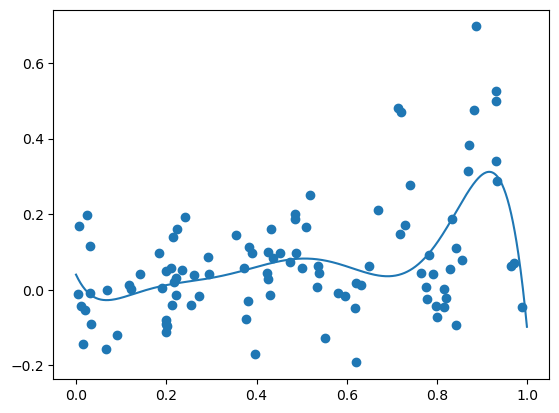

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
from math import sin, pi
from numpy import arange, vstack, argmax, asarray
from numpy.random import normal, random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings, simplefilter
from matplotlib import pyplot as plt

# target function to optimize
def target_function(x, noise_level=0.1):
    noise = normal(loc=0, scale=noise_level)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

# approximation of the target function using a model
def model_prediction(model, inputs):
    # suppress warnings during prediction
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(inputs, return_std=True)

# probability of improvement acquisition function
def prob_of_improvement(X_known, X_candidates, model, xi=0.01):
    # Predict the mean and standard deviation of the known points
    mu, sigma = model_prediction(model, X_known)
    # Best known value
    best = max(mu)
    
    # Predict the mean and standard deviation of the candidate points
    mu_cand, sigma_cand = model_prediction(model, X_candidates)
    
    # Calculate the probability of improvement
    imp = mu_cand - best - xi
    Z = imp / sigma_cand
    prob = norm.cdf(Z)
    
    return prob

# optimization of acquisition function to select next sample point
def optimize_acquisition(X_known, y_known, model):
    # generate random candidate points
    candidate_points = random(100).reshape(-1, 1)
    # evaluate acquisition scores for candidates
    scores = prob_of_improvement(X_known, candidate_points, model)
    # find the candidate with the highest score
    best_idx = argmax(scores)
    return candidate_points[best_idx, 0]

# visualize the true observations and the surrogate model's predictions
def visualize(X_known, y_known, model):
    # scatter plot of observed data points
    plt.scatter(X_known, y_known)
    # line plot of surrogate model predictions over domain
    domain_samples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    predictions, _ = model_prediction(model, domain_samples)
    plt.plot(domain_samples, predictions)
    plt.show()

# generate initial noisy samples from the domain
X_data = random(100).reshape(-1, 1)
y_data = asarray([target_function(x) for x in X_data]).reshape(-1, 1)

# initialize Gaussian Process model
gp_model = GaussianProcessRegressor()
gp_model.fit(X_data, y_data)

# visualize initial state of observations and surrogate model
visualize(X_data, y_data, gp_model)

# perform iterative optimization process
for iteration in range(100):
    # determine the next sampling point using acquisition function optimization
    next_sample = optimize_acquisition(X_data, y_data, gp_model)
    
    # evaluate the target function at the selected point
    observed_value = target_function(next_sample)
    
    # print progress information
    predicted_value, _ = model_prediction(gp_model, [[next_sample]])
    print(f'>x={next_sample:.3f}, predicted={predicted_value[0]:.6f}, actual={observed_value:.3f}')
    
    # update dataset with new sample and retrain the model
    X_data = vstack((X_data, [[next_sample]]))
    y_data = vstack((y_data, [[observed_value]]))
    
    gp_model.fit(X_data, y_data)

# visualize final state of observations and surrogate model predictions
visualize(X_data, y_data, gp_model)

# report the best result found during optimization
best_idx = argmax(y_data)
print(f'Best Result: x={X_data[best_idx][0]:.3f}, y={y_data[best_idx][0]:.3f}')


# Final Results